In [38]:
import numpy as np

In [39]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [40]:
def softmax_with_temperature(w: np.array, temperature: float) -> float:
    return softmax(-w / temperature)

In [41]:
w = np.array([15, 30, 200000, 500])  # Example weights
T = 0.5  # Temperature
 # Temperature
softmax_with_temperature(w,T)

array([1.00000000e+00, 9.35762297e-14, 0.00000000e+00, 0.00000000e+00])

In [42]:
def power_scaling(weights, alpha):
    scaled = weights ** alpha
    return scaled / scaled.sum()

In [43]:
T = 0.1  # Temperature
def power_scaling_with_temperature(w, T):
    return power_scaling(w, 1 - T)

In [44]:
w = np.array([15, 30, 200000, 500])  # Example weights
T = 0.8
res = power_scaling_with_temperature(w, T)
res

array([0.09217996, 0.10588697, 0.61606179, 0.18587127])

In [45]:
sum(res)

np.float64(1.0)

In [46]:
from pandas import read_csv
import numpy as np

In [47]:
def estimate_diverse_probability(age: int) -> float:
    """
    Returns the estimated probability (as a float between 0 and 1)
    that a person of the given age identifies as 'diverse'.

    This function models gender identity emergence based on age:
    - 0–3 years: assumed not to have established gender identity
    - 4–12 years: early self-identification possible (~1%)
    - 13–17 years: more frequent self-identification (~1.5%)
    - Adults follow survey-based estimations
    """

    if age < 0:
        raise ValueError("Age must be non-negative.")

    if age <= 3:
        return 0.0
    elif age <= 12:
        return 0.01
    elif age <= 17:
        return 0.015
    elif age <= 29:
        return 0.020
    elif age <= 44:
        return 0.010
    elif age <= 64:
        return 0.005
    else:
        return 0.002

In [48]:
# Load the dataset
from pandas import read_csv
path = '../../data/raw/altersaufbau-bevoelkerung-deutschland-zensus-2022.csv'
df = read_csv(path, sep=';', dtype={"age": str, "int": int, "female": int})
df["age"] = df["age"].replace("100+", "100")
df["age"] = df["age"].astype(int)

# Schritt 1: Gesamtbevölkerung pro Alter
df["total"] = df["male"] + df["female"]

# Schritt 2: Geschätzter Anteil divers
df["p_diverse"] = df["age"].apply(estimate_diverse_probability)
df["diverse"] = (df["total"] * df["p_diverse"]).round().astype(int)

# Schritt 3: Verbleibender Anteil (für male/female)
df["residual"] = df["total"] - df["diverse"]

# Verhältnis männlich/weiblich beibehalten (normieren auf 'residual')
total_known = df["male"] + df["female"]
df["male_share"] = df["male"] / total_known
df["female_share"] = df["female"] / total_known

df["male_adjusted"] = (df["residual"] * df["male_share"]).round().astype(int)
df["female_adjusted"] = (df["residual"] * df["female_share"]).round().astype(int)


df


,age,male,female,total,p_diverse,diverse,residual,male_share,female_share,male_adjusted,female_adjusted
0,0,345711,327669,673380,0.000,0,673380,0.513397,0.486603,345711,327669
1,1,359324,341616,700940,0.000,0,700940,0.512632,0.487368,359324,341616
2,2,381737,362425,744162,0.000,0,744162,0.512976,0.487024,381737,362425
3,3,408588,388442,797030,0.000,0,797030,0.512638,0.487362,408588,388442
4,4,401941,381675,783616,0.010,7836,775780,0.512931,0.487069,397922,377858
...,...,...,...,...,...,...,...,...,...,...,...
96,96,10303,32072,42375,0.002,85,42290,0.243139,0.756861,10282,32008
97,97,6491,21961,28452,0.002,57,28395,0.228139,0.771861,6478,21917
98,98,3918,15147,19065,0.002,38,19027,0.205507,0.794493,3910,15117
99,99,2298,10167,12465,0.002,25,12440,0.184356,0.815644,2293,10147


In [49]:
# Save the adjusted DataFrame to a new CSV file
import os
if not os.path.exists('../../data/processed'):
    os.makedirs('../../data/processed')
output_path = '../../data/processed/altersaufbau-bevoelkerung-deutschland-zensus-2022-adjusted.csv'
out_df = df[['age', 'total', 'male_adjusted', 'female_adjusted', 'diverse']]
out_df.to_csv(output_path, sep=';', index=False)

In [50]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

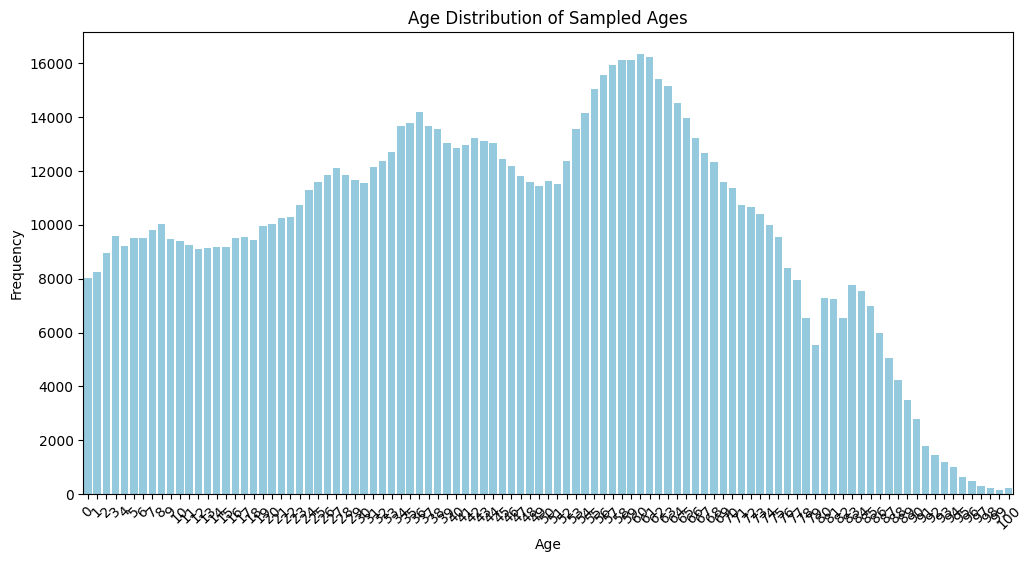

In [51]:
from persona_generator.sampler.age_sampler import AgeSampler

ages = AgeSampler(out_df).sample_n(1000000)
# plot age-distribution
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

age_distribution = pd.Series(ages).value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=age_distribution.index, y=age_distribution.values, color='skyblue')
plt.title("Age Distribution of Sampled Ages")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

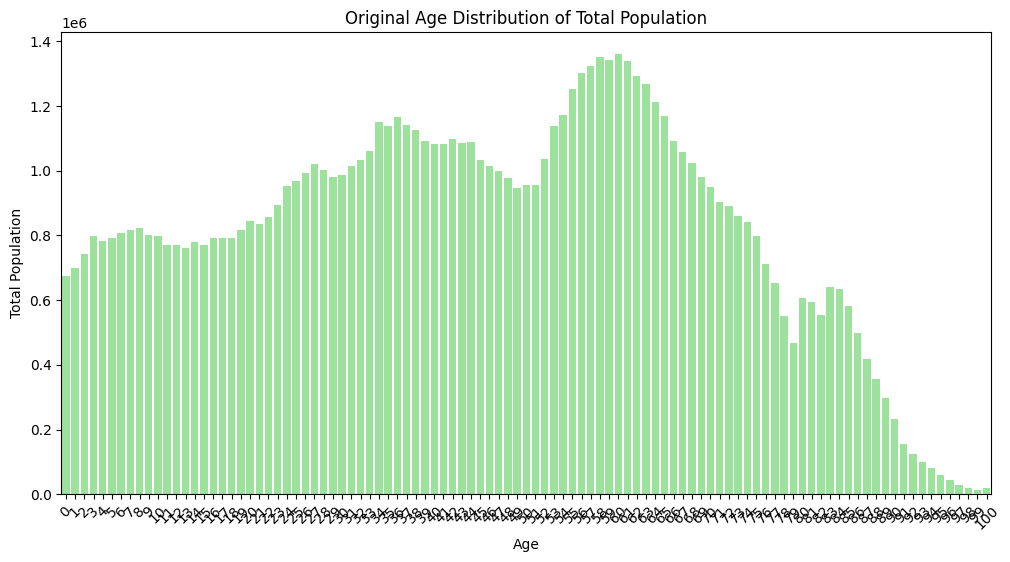

In [52]:
# plot original age distribution of total population
original_age_distribution = df.set_index('age')['total']
plt.figure(figsize=(12, 6))
sns.barplot(x=original_age_distribution.index, y=original_age_distribution.values, color='lightgreen')
plt.title("Original Age Distribution of Total Population")
plt.xlabel("Age")
plt.ylabel("Total Population")
plt.xticks(rotation=45)
plt.show()

In [53]:
from persona_generator.sampler.gender_sampler import GenderSampler

In [ ]:
gender_sampler = GenderSampler(out_df, temperature=.7)
genders = gender_sampler.sample_n(np.array(ages))

# Alter als Feld einfügen!
age_gender_pairs = [{"age": i, "male": 0, "female": 0, "diverse": 0} for i in range(101)]

for i in range(len(ages)):
    age = ages[i]
    gender = genders[i]
    age_gender_pairs[age][gender] += 1

# Index kannst du weglassen, columns ist optional:
df_age_gender = pd.DataFrame(age_gender_pairs)
df_age_gender.set_index("age", inplace=True)

df_age_gender

,male,female,diverse
age,,,
0,4095,3945,0
1,4143,4100,0
2,4600,4338,0
3,4891,4700,0
4,4427,4196,606
...,...,...,...
96,169,309,24
97,87,209,11
98,66,147,9


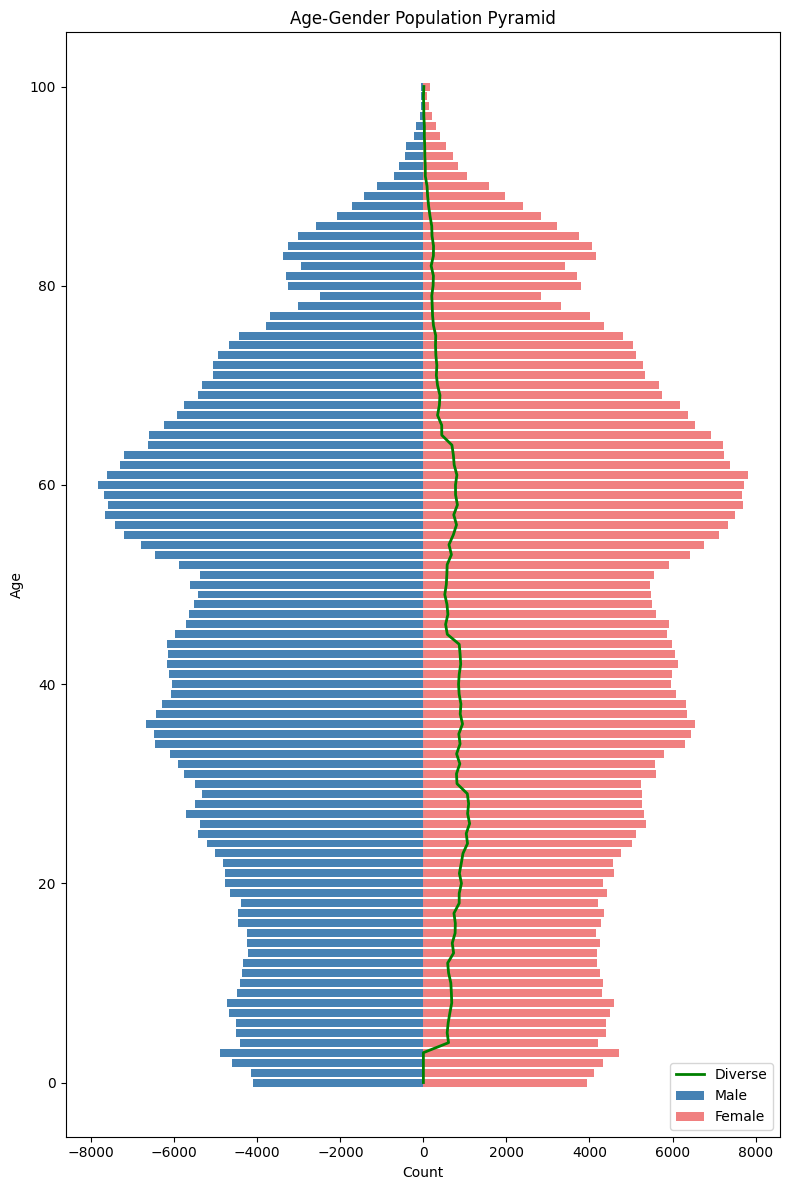

In [55]:
import matplotlib.pyplot as plt

ages = df_age_gender.index           # Alter als Index
male = -df_age_gender["male"]        # Negativ für links
female = df_age_gender["female"]     # Positiv für rechts

plt.figure(figsize=(8, 12))
plt.barh(ages, male, color="steelblue", label="Male")
plt.barh(ages, female, color="lightcoral", label="Female")

plt.xlabel("Count")
plt.ylabel("Age")
plt.title("Age-Gender Population Pyramid")
plt.legend(loc="lower right")

# Optional: Divers
if "diverse" in df_age_gender.columns:
    plt.plot(df_age_gender["diverse"], ages, color="green", label="Diverse", linewidth=2)
    plt.legend(loc="lower right")

plt.tight_layout()
plt.show()


In [56]:
out_df.head()

,age,total,male_adjusted,female_adjusted,diverse
0,0,673380,345711,327669,0
1,1,700940,359324,341616,0
2,2,744162,381737,362425,0
3,3,797030,408588,388442,0
4,4,783616,397922,377858,7836


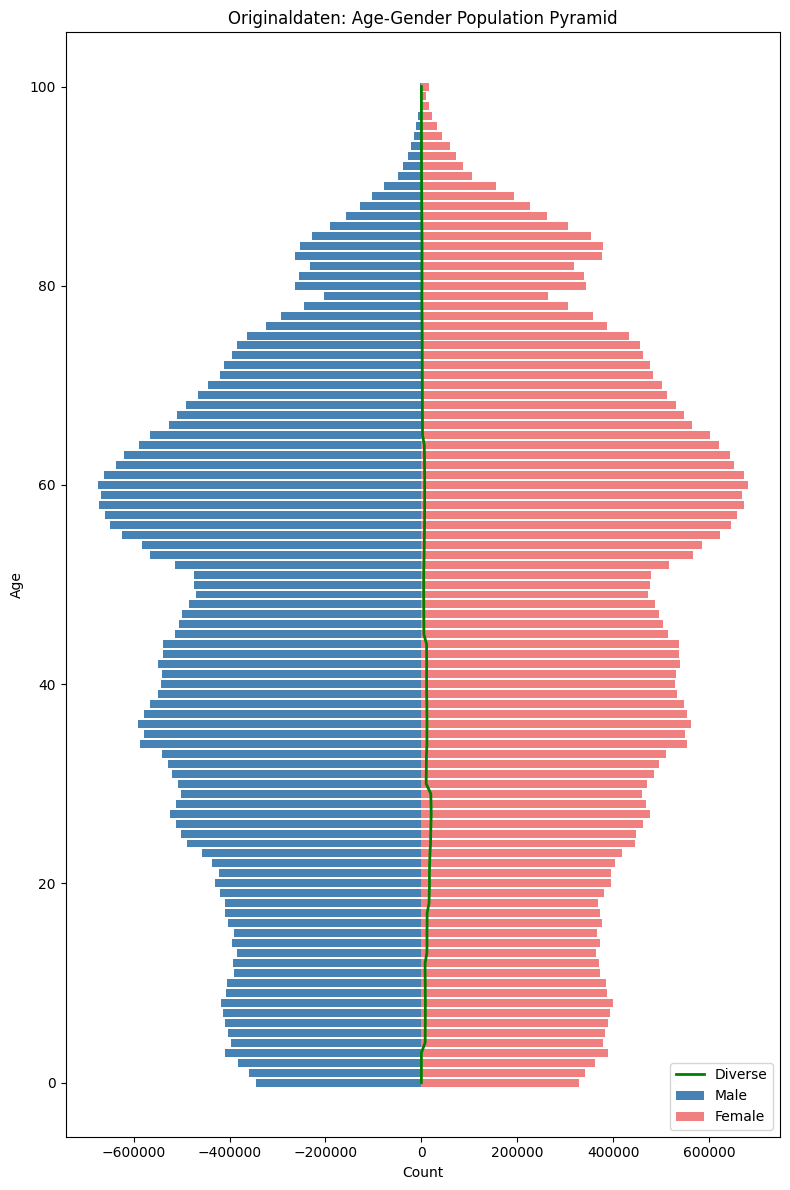

In [57]:
import matplotlib.pyplot as plt

# Daten aus out_df
ages = out_df["age"]
male = -out_df["male_adjusted"]         # Negativ für links
female = out_df["female_adjusted"]      # Positiv für rechts

plt.figure(figsize=(8, 12))
plt.barh(ages, male, color="steelblue", label="Male")
plt.barh(ages, female, color="lightcoral", label="Female")

plt.xlabel("Count")
plt.ylabel("Age")
plt.title("Originaldaten: Age-Gender Population Pyramid")
plt.legend(loc="lower right")

# Optional: Diverse
if "diverse" in out_df.columns:
    plt.plot(out_df["diverse"], ages, color="green", label="Diverse", linewidth=2)
    plt.legend(loc="lower right")

plt.tight_layout()
plt.show()
